# Setup

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import sys

from deap import algorithms, base, creator, tools

from sympy import *

from scipy.stats import spearmanr

sys.path.append('../promoter_solving/')
from promoter_solving_core import *

In [24]:
# Load csv with mRNA_ratio, MA_act, MA_inh
data = pd.read_csv('../data/pickle_dfs/zerod_M_MA_for_activator_inhibitor_and_mRNA_ratios_df.csv', index_col=0)
data.head()

,MA_activator,MA_inhibitor,actual_mRNA_ratio
control__wt_glc__1,0.019182,0.028499,2.186692
control__wt_glc__2,-0.019182,-0.028499,2.369230
fur__wt_dpd__1,-0.963901,-0.473642,0.490542
fur__wt_dpd__2,-1.116929,-0.541595,0.492320
fur__wt_fe__1,0.043720,-0.054857,1.756930


# Create Grids for Each Condition

In [124]:
grid = pd.DataFrame(columns = ['mRNA_ratio','grid'], index = data.index)
grid.loc[:,'mRNA_ratio'] = data.loc[:,'actual_mRNA_ratio']

In [125]:
equation = sympify('Eq(mRNARatio,((cActivator*KdRNAP + KdRNAPCrp)*(KdRNAP + RNAP + \
KeqOpening*RNAP))/((1 + cActivator + cInhibitor)*KdRNAP*KdRNAPCrp + \
cActivator*KdRNAP*(1 + KeqOpening)*RNAP + KdRNAPCrp*(1 + \
KeqOpening)*RNAP))')
equation

Eq(mRNARatio, (KdRNAP*cActivator + KdRNAPCrp)*(KdRNAP + KeqOpening*RNAP + RNAP)/(KdRNAP*KdRNAPCrp*(cActivator + cInhibitor + 1) + KdRNAP*RNAP*cActivator*(KeqOpening + 1) + KdRNAPCrp*RNAP*(KeqOpening + 1)))

In [126]:
# Define constants
constant_vals = {
    # NOTE: MAKE SURE TO UPDATE IF ANYTHING IS CHANGED
    'KdRNAP': 10**-5,
    'KdRNAPCrp': 2.5118864315095796e-07*1.4,
    'KeqOpening': 10**-0.34444956947383365,
    'RNAP': 10**-6, 
}

In [127]:
# Create lambda functions that we can plug in to
lambda_df = create_lambdas(equation, constant_vals)

# Parameter we are solving for using the other two
solve = 'cInhibitor' # Solve for this by setting the other (e.g. solve = cInhibitor if cActivator is known)

input_range = {
    'cActivator': [0,10],
    #'cInhibitor': [0,50],
}

for i, condition in enumerate(grid.index):
    # Create a working grid based on cActivator, we will add cInhibitor values 
    # to it to ensure they always result in mRNA ratio
    working_grid = create_parameter_grid(num_steps = 101, **input_range)

    # Use a dict just in case order of tuple to sub into lambda function ever changes
    values = {'mRNARatio': grid.loc[condition,'mRNA_ratio']}
    for ii, pair in enumerate(working_grid):
        values[list(input_range.keys())[0]] = pair[0] #NOTE: May break if we try to run both at same time
        
        # Create a tuple in the correct order to pass into the lambda function
        values_tuple = tuple([values[p] for p in lambda_df.loc[solve,'order']])
    
        # Evaluate the lambda function, order is currently (cActivator, cInhibitor)
        working_grid[ii] += ((lambda_df.loc[solve,'lambda'](values_tuple))[0],)
    
    # Save to grid df
    grid.at[condition, 'grid'] = working_grid

In [472]:
# Create a combined grid
# Create lambda functions that we can plug in to
lambda_df = create_lambdas(equation, constant_vals)

cAct_range = {'cActivator': [0,10]}
cInh_range = {'cInhibitor': [0,4]} # Use a log10 range and convert back after creating grid

for i, condition in enumerate(grid.index):
    # Create a working grid based on cActivator, we will add cInhibitor values 
    # to it to ensure they always result in mRNA ratio
    cAct_grid = create_parameter_grid(num_steps = 51, **cAct_range)
    cInh_grid = create_parameter_grid(num_steps = 51, **cInh_range)
    cInh_grid = [[10**x[0]] for x in cInh_grid]

    # Use a dict just in case order of tuple to sub into lambda function ever changes
    values = {'mRNARatio': grid.loc[condition,'mRNA_ratio']}
    for ii, pair in enumerate(cAct_grid):
        values['cActivator'] = pair[0] # Add cAct to values dict
        
        # Create a tuple in the correct order to pass into the lambda function
        values_tuple = tuple([values[p] for p in lambda_df.loc['cInhibitor','order']])
    
        # Evaluate the lambda function, order is currently (cActivator, cInhibitor)
        cAct_grid[ii] += ((lambda_df.loc['cInhibitor','lambda'](values_tuple))[0],)

    values = {'mRNARatio': grid.loc[condition,'mRNA_ratio']}
    for ii, pair in enumerate(cInh_grid):
        values['cInhibitor'] = pair[0] # Add cInh to values dict
        
        # Create a tuple in the correct order to pass into the lambda function
        values_tuple = tuple([values[p] for p in lambda_df.loc['cActivator','order']])
    
        # Evaluate the lambda function, order is currently (cActivator, cInhibitor)
        cInh_grid[ii] = ((lambda_df.loc['cActivator','lambda'](values_tuple))[0],cInh_grid[ii][0]) # Need to reverse the tuples to maintain (cAct, cInh) order when combining the two grids
    
    working_grid = sorted(cAct_grid + cInh_grid)
    
    # Save to grid df
    grid.at[condition, 'grid'] = working_grid

In [128]:
grid.head()

,mRNA_ratio,grid
control__wt_glc__1,2.186692,"[(0.0, -0.6215098252031866), (0.1, 0.354773407..."
control__wt_glc__2,2.369230,"[(0.0, -0.6618609214775106), (0.1, 0.199679019..."
fur__wt_dpd__1,0.490542,"[(0.0, 1.1894055061723103), (0.1, 7.3152485865..."
fur__wt_dpd__2,0.492320,"[(0.0, 1.180971427188386), (0.1, 7.28283116958..."
fur__wt_fe__1,1.756930,"[(0.0, -0.49339972486388645), (0.1, 0.84718029..."


# DEAP

In [30]:
creator.create(name = 'fitness',
               base = base.Fitness,
               weights = (1.0, -1.0,)) # Set to maximize Spearman correlation of MA_activator and cActivator, and minimize MA_inhibitor and cInhibitor

creator.create(name = 'individual',
               base = np.ndarray,
               fitness = creator.fitness)

toolbox = base.Toolbox()

random.seed(42)

def generate_individual(individual_class: type, data: pd.DataFrame):
    individual = individual_class(random.sample(grid,1)[0] for grid in grid['grid'])
    
    return individual

toolbox.register(alias = 'individual',
                 function = generate_individual,
                 individual_class = creator.individual,
                 data = grid)

toolbox.register('population',
                 tools.initRepeat,
                 list,
                 toolbox.individual)

In [31]:
# Evaluate
MA_df = data.iloc[:,0:2]

def spearman_objective(individual: object, MA_df: pd.DataFrame):
    """
    Calculate spearman coefficient between cAct/cInh and MA_act/MA_inh
    :param object individual: DEAP individual
    :param pd.DataFrame MA_df: Df with columns = ['MA_activator','MA_inhibitor']
    """

    MA_activator = MA_df.loc[:,'MA_activator']
    MA_inhibitor = MA_df.loc[:,'MA_inhibitor']
    
    # NOTE: Need to swap 0 and 1 depending if calculating using cInhibitor or cActivator
    # NOTE: This is hardcoded and may break depending on if we try to run the two simultaneously
    if solve == 'cInhibitor':
        ind_activator = individual[:,0]
        ind_inhibitor = individual[:,1]
    else:
        ind_activator = individual[:,1]
        ind_inhibitor = individual[:,0]
    
    activator_spearman = spearmanr(MA_activator, ind_activator)[0]
    inhibitor_spearman = spearmanr(MA_inhibitor, ind_inhibitor)[0]
    
    return activator_spearman, inhibitor_spearman,

toolbox.register(alias = 'evaluate', function = spearman_objective, MA_df = MA_df)

In [32]:
toolbox.register("select", tools.selNSGA2, nd='log')

In [33]:
# Mutation
def mutate(individual: object, prob: float, data: pd.DataFrame):
    for i, _ in enumerate(individual):
        if random.random() < prob:
            individual[i] = random.sample(grid.iloc[i,1],1)[0]

    return individual,

mt_prob = 0.1  #NOTE: CHANGE ME
toolbox.register('mutate', function = mutate, prob = mt_prob, data = data)

In [34]:
# Crossover
def crossover(ind_one: object, ind_two: object, prob: float,):

    for i, _ in enumerate(ind_one):
        if random.random() < prob:
            ind_one[i], ind_two[i] = ind_two[i].copy(), ind_one[i].copy()

    return ind_one, ind_two

cx_prob = 0.1 # NOTE: CHANGE ME

toolbox.register(alias = "mate", function = crossover, prob = cx_prob,)

In [245]:
best_score = None  # To store the best weighted score across generations

def weighted_score(individual):
    # Assuming the fitness values are in the order of your objectives
    # For example, if the objectives are (obj1, obj2), then individual.fitness.values will be (obj1_value, obj2_value)

    # Define the weights for the objectives
    weights = (1.0, -1.0)

    # Calculate the weighted score by multiplying the fitness values with the corresponding weights
    score = sum(weight * value for weight, value in zip(weights, individual.fitness.values))

    return score

def update_best_score(population):
    global best_score
    # Calculate the weighted scores for each individual in the population
    weighted_scores = [weighted_score(ind) for ind in population]

    # Find the best individual's score based on the weighted scores
    best_score = max(weighted_scores)

    return None

In [276]:
def best_score(ind):
    """
    Returns a list containing the total scores for each individual and a list 
    containining the np.argsort indices for the ascending sorted scores

    :param list population: List of individuals with fitness scores
    """
    print(ind)
    a, b = ind
    score = np.subtract(a,b) # Since objective weights are (1.0, -1.0)

    return score

In [279]:
pop[0].fitness.values[0]

0.735594130226871

In [280]:
stats = tools.Statistics(key=lambda ind: np.subtract(ind.fitness.values[0],ind.fitness.values[1]))
stats.register("max", np.max)

In [281]:
stats.compile(pop)

{'max': 1.5664759583045655}

In [261]:
stats = tools.Statistics(lambda ind: ind.fitness.values) # NOTE: update these to actually be useful
stats.register("best", best_score)
stats.register("min", np.min, axis=0)
stats.register("max", np.max, axis=0)

In [90]:
def best_individual(population: list):
    """
    Returns a list containing the total scores for each individual and a list 
    containining the np.argsort indices for the ascending sorted scores

    :param list population: List of individuals with fitness scores
    """
    a, b = zip(*[population[i].fitness.values for i in range(len(population))])
    total_scores = np.subtract(a,b) # Since objective weights are (1.0, -1.0)
    sorted_index = np.argsort(total_scores)

    return total_scores, sorted_index

In [132]:
# Rather than deal with having to look up where the tuple is, I think my next step should be to make the first n tuples correspond to the locations of the n parameters that are set in each tuple
# For this case, that would mean that the first number would correspond to the position of the cAct value in the list
def create_greedy_offspring(base_individual: object,
                            n_steps: int,
                            grid: pd.Series):
    """
    Returns a population of modified individuals that have different parameters
    for one condition

    :param object base_individual: Individual to copy parameters from
    :param int n_steps: Distance from current parameters to test combinations
    :param pd.Series grid: Series containing grids for each condition
    """
    
    # Create population to hold the individuals we are trying out
    population = toolbox.population(n=0)
    step_list = [step for step in range(-n_steps, n_steps+1) if step != 0]

    for i, (act, inh) in enumerate(base_individual): # Iterate over each condition's parameters in the hof individual
        # Only need to do this once per condition
        for ii, (grid_act, grid_inh) in enumerate(grid[i]): # Locate the position of the tuple in the grid. I'm worried about rounding errors, so I want to shift to the method described above.
            if (act, inh) == (grid_act, grid_inh):
                position = ii

        for step in step_list:
            # Not treating the parameters as if they wrap around
            if -1 < position+step < len(grid[i]):
                temp_individual = creator.individual(base_individual) # Create a copy of the base individual
                temp_individual[i] = grid[i][position+step] # Replace the parameters with the neighbors
                population.append(temp_individual) # Add the temp_individual to the selection pool

    return population

In [212]:
def mu_plus_lambda(population = list,
                   toolbox = base.Toolbox(),
                   mu = int,
                   lambda_ = int,
                   cxpb = float,
                   mutpb = float,
                   n_gen = int,
                   n_steps = int,
                   grid = pd.Series,
                   stats = None,
                   hall_of_fame = None,
                   verbose = __debug__):
    """
    Modified DEAP mu+lambda evolutionary algorithm using varOr

    :param list population: List of individuals to serve as the starting population
    :param base.Toolbox() toolbox: DEAP class containing evolution operators
    :param int mu: Number of individuals to select for the next generation
    :param int lambda_: Number of children to produce at each generation
    :param float cxpb: Probability that an offspring is produced by crossover
    :param float mutpb: Probability that an offspring is produced by mutation
    :param int n_gen: Number of generations to run
    :param int n_steps: Distance from current parameters to test combinations
    :param pd.Series grid: Series containing grids for each condition
    :param stats: DEAP class containing the types of statistics to record in the logbook
    :param halloffame: DEAP class containing the best individuals evaluated
    :param verbose: Whether or not to print statistics for each generation
    :returns list pop: Final population
    :returns logbook: DEAP class containing stats for every generation

    evaluate(population)
    for g in range(ngen):
        offspring = varOr(population, toolbox, lamda_, cxpb, mutpb)
        evaluate(offspring)
        gradient_offspring = create_gradient_offspring(hof[0], toolbox)
        evaluate(gradient_offspring)
        population = select(population+offspring+gradient_offspring, mu)
    """

    logbook = tools.Logbook()
    logbook.header = ['gen', 'nevals', 'best'] + (stats.fields if stats else [])

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in population if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    if hall_of_fame is not None:
        hall_of_fame.update(population)

    total_scores, sorted_index = best_individual(population)

    record = stats.compile(population) if stats is not None else {}
    logbook.record(gen=0, nevals=len(invalid_ind), best=total_scores[sorted_index[-1]], **record)
    if verbose:
        print(logbook.stream)

    # Begin the generational process
    for gen in range(1, n_gen + 1):
        # Vary the population
        offspring = algorithms.varOr(population, toolbox, lambda_, cxpb, mutpb)

        # Greedy offspring
        offspring = offspring+create_greedy_offspring(population[sorted_index[-1]], n_steps, grid)

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # Update the hall of fame with the generated individuals
        # NOTE: I feel like HoF should update after the next population is created? That way we only have to compare max mu individuals to the HoF?
        if hall_of_fame is not None:
            hall_of_fame.update(offspring)

        # Select the next generation population
        population[:] = toolbox.select(population + offspring, mu)

        # Update the statistics with the new population
        total_scores, sorted_index = best_individual(population)

        record = stats.compile(population) if stats is not None else {}
        logbook.record(gen=gen, nevals=len(invalid_ind), best=total_scores[sorted_index[-1]], **record)
        if verbose:
            print(logbook.stream)

    return population, logbook

In [282]:
# NOTE: Using np.ndarray individuals requires a different method to compare individuals
nind = 100
mu = 100
lambda_ = 100
cxpb = 0.7
mutpb = 0.3
n_gen = 1000
n_steps = 1

hof = tools.ParetoFront(similar=np.array_equal)

# pop, logbook = mu_plus_lambda(toolbox.population(n=nind), toolbox, mu=mu, lambda_=lambda_, cxpb=cxpb, mutpb=mutpb, n_gen=n_gen, n_steps = n_steps, grid = grid.grid, stats=stats, hall_of_fame=hof, verbose=True)
pop, logbook = algorithms.eaMuPlusLambda(toolbox.population(n=nind), toolbox, mu=mu, lambda_=lambda_, cxpb=cxpb, mutpb=mutpb, ngen=n_gen, stats=stats, halloffame=hof, verbose=True)

gen	nevals	max     
0  	100   	0.762419
1  	100   	0.790744
2  	100   	0.790744
3  	100   	0.810074
4  	100   	0.839986
5  	100   	0.869327
6  	100   	0.879139
7  	100   	0.915582
8  	100   	0.923197
9  	100   	0.923197
10 	100   	0.928937
11 	100   	0.936128
12 	100   	0.945169
13 	100   	0.967095
14 	100   	0.976563
15 	100   	0.981751
16 	100   	1.00107 
17 	100   	1.01351 
18 	100   	1.03065 
19 	100   	1.05187 
20 	100   	1.05348 
21 	100   	1.06039 
22 	100   	1.10148 
23 	100   	1.11362 
24 	100   	1.11362 
25 	100   	1.12325 
26 	100   	1.12325 
27 	100   	1.13011 
28 	100   	1.13026 
29 	100   	1.13026 
30 	100   	1.14715 
31 	100   	1.15247 
32 	100   	1.15247 
33 	100   	1.16517 
34 	100   	1.16517 
35 	100   	1.16517 
36 	100   	1.16517 
37 	100   	1.16517 
38 	100   	1.18455 
39 	100   	1.18455 
40 	100   	1.19267 
41 	100   	1.1946  
42 	100   	1.20327 
43 	100   	1.21152 
44 	100   	1.22142 
45 	100   	1.22142 
46 	100   	1.24178 
47 	100   	1.24178 
48 	100   	1.25136 


## Visualizing GA results

In [190]:
total_score, total_sort = best_individual(pop)

In [191]:
total_score[total_sort[-1]]

1.5664759583045655

In [192]:
hof_score, hof_sort = best_individual(hof)

In [193]:
hof_score[hof_sort[-1]]

1.5668486312671008

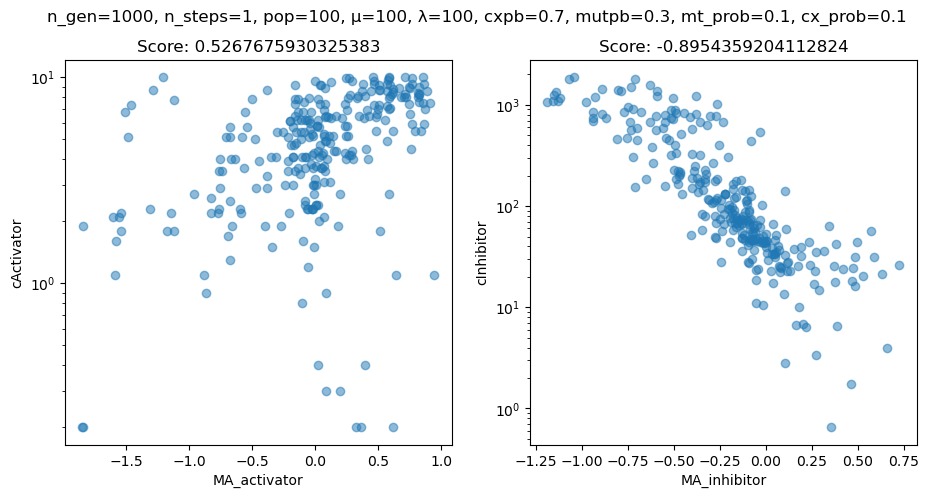

In [194]:
plot_individual = pop[total_sort[0]]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (11,5), squeeze= True)
title = 'n_gen='+str(n_gen)+', n_steps='+str(n_steps)+', pop='+str(nind)+', μ='+str(mu)+', λ='+str(lambda_)+', cxpb='+str(cxpb)+', mutpb='+str(mutpb)+', mt_prob='+str(mt_prob)+', cx_prob='+str(cx_prob)
fig.suptitle(title)
ax1.set_xlabel('MA_activator')
ax2.set_xlabel('MA_inhibitor')
ax1.set_ylabel('cActivator')
ax2.set_ylabel('cInhibitor')
ax1.set_yscale('log')
ax2.set_yscale('log')

eval_act, eval_inh = toolbox.evaluate(plot_individual)
ax1.set_title('Score: '+str(eval_act))
ax2.set_title('Score: '+str(eval_inh))

if solve == 'cInhibitor':
    # If cActivator is used to calculate cInhibitor
    ax1.scatter(MA_df.iloc[:,0], plot_individual[:,0], alpha=0.5)
    ax2.scatter(MA_df.iloc[:,1], plot_individual[:,1], alpha=0.5)
else: 
    # If cInhibitor is used to calculate cActivator
    ax1.scatter(MA_df.iloc[:,0], plot_individual[:,1], alpha=0.5)
    ax2.scatter(MA_df.iloc[:,1], plot_individual[:,0], alpha=0.5)

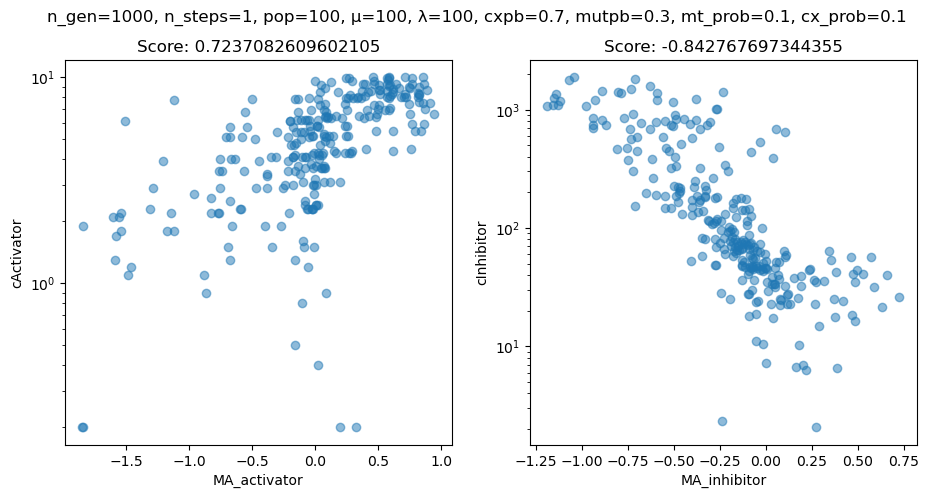

In [195]:
plot_individual = pop[total_sort[-1]]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (11,5), squeeze= True)
title = 'n_gen='+str(n_gen)+', n_steps='+str(n_steps)+', pop='+str(nind)+', μ='+str(mu)+', λ='+str(lambda_)+', cxpb='+str(cxpb)+', mutpb='+str(mutpb)+', mt_prob='+str(mt_prob)+', cx_prob='+str(cx_prob)
fig.suptitle(title)
ax1.set_xlabel('MA_activator')
ax2.set_xlabel('MA_inhibitor')
ax1.set_ylabel('cActivator')
ax2.set_ylabel('cInhibitor')
ax1.set_yscale('log')
ax2.set_yscale('log')

eval_act, eval_inh = toolbox.evaluate(plot_individual)
ax1.set_title('Score: '+str(eval_act))
ax2.set_title('Score: '+str(eval_inh))

if solve == 'cInhibitor':
    # If cActivator is used to calculate cInhibitor
    ax1.scatter(MA_df.iloc[:,0], plot_individual[:,0], alpha=0.5)
    ax2.scatter(MA_df.iloc[:,1], plot_individual[:,1], alpha=0.5)
else: 
    # If cInhibitor is used to calculate cActivator
    ax1.scatter(MA_df.iloc[:,0], plot_individual[:,1], alpha=0.5)
    ax2.scatter(MA_df.iloc[:,1], plot_individual[:,0], alpha=0.5)

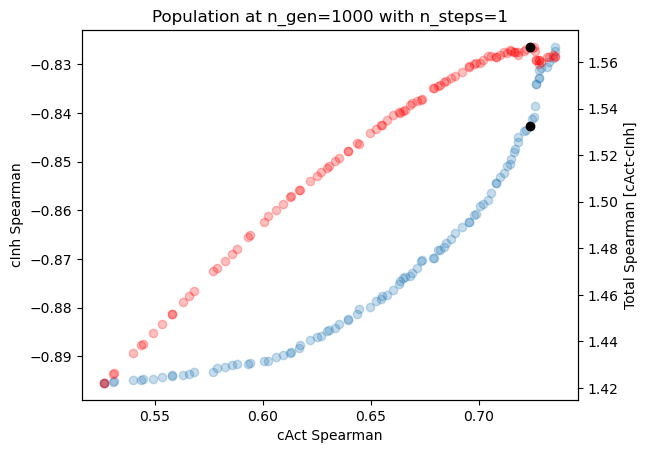

In [196]:
# Plot the final population and their total score
a, b = zip(*[pop[i].fitness.values for i in range(len(pop))])

fig, ax1 = plt.subplots()
ax1.scatter(a, b, alpha=0.25)
ax2 = ax1.twinx()
ax2.scatter(a, total_score, alpha=0.25, c='r')
ax1.set_title('Population at n_gen='+str(n_gen)+' with n_steps='+str(n_steps))
ax1.set_xlabel('cAct Spearman')
ax1.set_ylabel('cInh Spearman')
ax2.set_ylabel('Total Spearman [cAct-cInh]')
ax1.scatter(a[total_sort[-1]], b[total_sort[-1]], c='k')
ax2.scatter(a[total_sort[-1]], total_score[total_sort[-1]], c='k')

Text(0.5, 0, 'Generation')

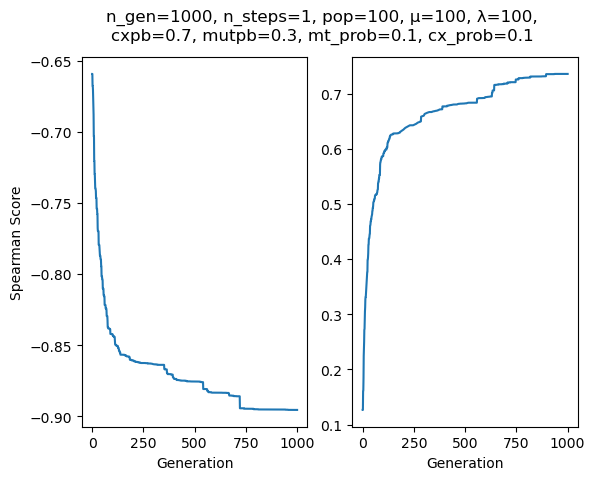

In [197]:
# Plot fitness of best individuals over time and compare to hof
gen = np.linspace(0, n_gen, n_gen+1)
gen_min = []
gen_max = []

for gen_dict in logbook:
    gen_min.append(gen_dict['min'])
    gen_max.append(gen_dict['max'])

fig, [ax1, ax2] = plt.subplots(1,2)
title = 'n_gen='+str(n_gen)+', n_steps='+str(n_steps)+', pop='+str(nind)+', μ='+str(mu)+', λ='+str(lambda_)+',\ncxpb='+str(cxpb)+', mutpb='+str(mutpb)+', mt_prob='+str(mt_prob)+', cx_prob='+str(cx_prob)
fig.suptitle(title)
ax1.plot(gen, gen_min)
ax1.set_xlabel('Generation')
ax1.set_ylabel('Spearman Score')

ax2.plot(gen, gen_max)
ax2.set_xlabel('Generation')

Text(0, 0.5, 'Total Spearman [cAct-cInh]')

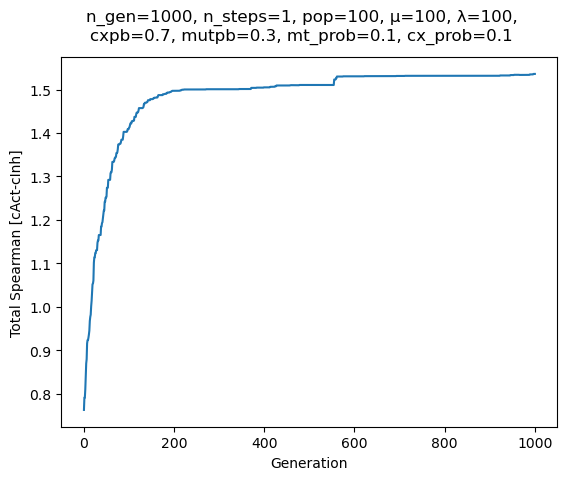

In [285]:
# Plot fitness of best individuals over time and compare to hof
gen = np.linspace(0, n_gen, n_gen+1)
gen_score = []

for gen_dict in logbook:
    gen_score.append(gen_dict['max'])

fig, ax = plt.subplots()
title = 'n_gen='+str(n_gen)+', n_steps='+str(n_steps)+', pop='+str(nind)+', μ='+str(mu)+', λ='+str(lambda_)+',\ncxpb='+str(cxpb)+', mutpb='+str(mutpb)+', mt_prob='+str(mt_prob)+', cx_prob='+str(cx_prob)
fig.suptitle(title)
ax.plot(gen, gen_score)
ax.set_xlabel('Generation')
ax.set_ylabel('Total Spearman [cAct-cInh]')

## "Greedy Offspring"

In [116]:
# Effect on scores
base_individual = pop[total_sort[-1]]
n_steps = 10
temp_population = create_greedy_offspring(base_individual, n_steps, grid.grid)+pop
c, d = zip(*[temp_population[i].fitness.values for i in range(len(temp_population))])
test_total_score = np.subtract(c,d)
test_total_sort = np.argsort(test_total_score)
test_best_location = test_total_sort[-1]
test_best_individual = temp_population[test_best_location]

ValueError: not enough values to unpack (expected 2, got 0)

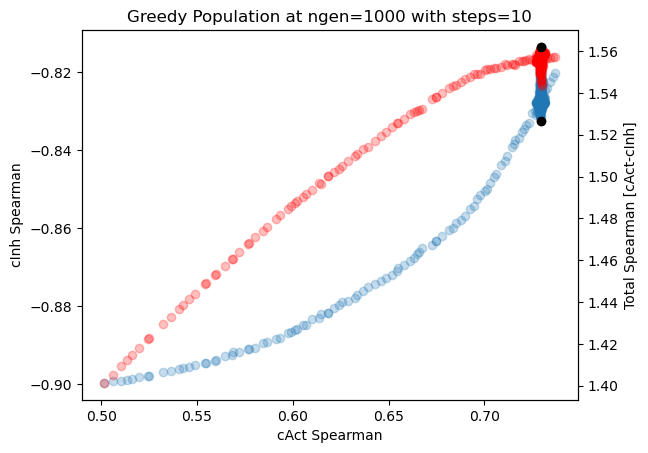

In [84]:
# Plot the final population and their total score
fig, ax1 = plt.subplots()
ax1.scatter(c, d, alpha=0.25)
ax2 = ax1.twinx()
ax2.scatter(c, test_total_score, alpha=0.25, c='r')
ax1.set_title('Greedy Population at ngen='+str(ngen)+' with steps='+str(n_steps))
ax1.set_xlabel('cAct Spearman')
ax1.set_ylabel('cInh Spearman')
ax2.set_ylabel('Total Spearman [cAct-cInh]')
ax1.scatter(c[test_best_location], d[test_best_location], c='k')
ax2.scatter(c[test_best_location], test_total_score[test_best_location], c='k')

In [86]:
test_total_score[test_total_sort]

array([1.40128868, 1.40517133, 1.40947944, ..., 1.56065093, 1.56145226,
       1.56202629])

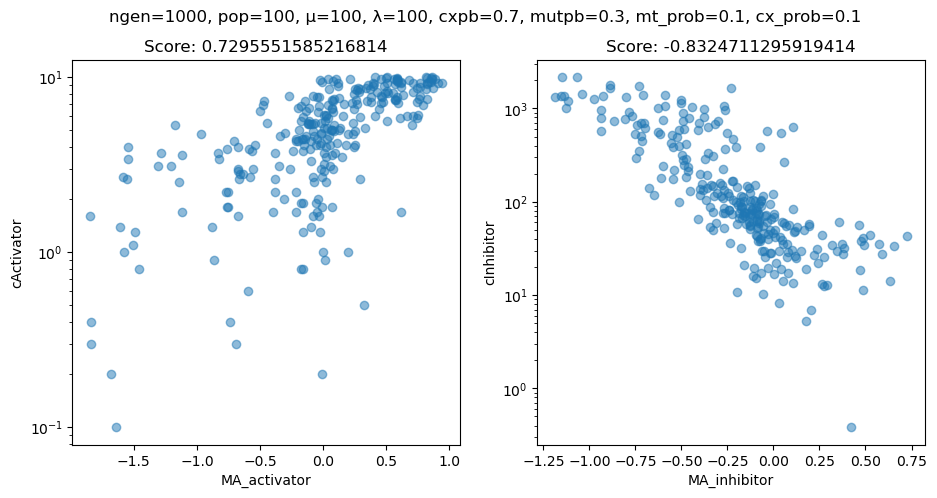

In [73]:
plot_individual = temp_population[test_total_sort[-1]]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (11,5), squeeze= True)
title = 'ngen='+str(ngen)+', pop='+str(nind)+', μ='+str(mu)+', λ='+str(lambda_)+', cxpb='+str(cxpb)+', mutpb='+str(mutpb)+', mt_prob='+str(mt_prob)+', cx_prob='+str(cx_prob)
fig.suptitle(title)
ax1.set_xlabel('MA_activator')
ax2.set_xlabel('MA_inhibitor')
ax1.set_ylabel('cActivator')
ax2.set_ylabel('cInhibitor')
ax1.set_yscale('log')
ax2.set_yscale('log')

eval_act, eval_inh = toolbox.evaluate(plot_individual)
ax1.set_title('Score: '+str(eval_act))
ax2.set_title('Score: '+str(eval_inh))

if solve == 'cInhibitor':
    # If cActivator is used to calculate cInhibitor
    ax1.scatter(MA_df.iloc[:,0], plot_individual[:,0], alpha=0.5)
    ax2.scatter(MA_df.iloc[:,1], plot_individual[:,1], alpha=0.5)
else: 
    # If cInhibitor is used to calculate cActivator
    ax1.scatter(MA_df.iloc[:,0], plot_individual[:,1], alpha=0.5)
    ax2.scatter(MA_df.iloc[:,1], plot_individual[:,0], alpha=0.5)

In [22]:
n_steps = 3
step_list = [step for step in range(-n_steps, n_steps+1) if step != 0]
print(step_list)

test_list = [0, 1, 2, 3, 4]
test_position = 3
print(test_list[test_position])

for step in step_list:
    if -1 < test_position+step < len(test_list):
        print(test_list[test_position+step])

[-3, -2, -1, 1, 2, 3]
3
0
1
2
4
